In [32]:
# 02_tf_embedding_extraction.ipynb
# TensorFlow ResNet50을 이용한 이미지 임베딩 추출

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import os
import time
from matplotlib import rc
rc('font', family='NanumGothic')

# GPU 설정 확인
print(f"TensorFlow 버전: {tf.__version__}")
print(f"GPU 사용 가능: {tf.config.list_physical_devices('GPU')}")

TensorFlow 버전: 2.20.0-rc0
GPU 사용 가능: []


## 데이터 로드

In [33]:
try:
    styles = pd.read_csv('processed_styles.csv')
    print(f"전처리된 데이터 로드: {len(styles):,}개")
except FileNotFoundError:
    # 직접 로드 및 전처리
    print("전처리된 파일이 없음")
    
    csv_path = '../data/fashion-dataset/styles.csv'
    image_dir = '../data/fashion-dataset/images'
    
    styles = pd.read_csv(csv_path, on_bad_lines='skip')
    styles = styles.dropna(subset=['id'])
    styles['id'] = styles['id'].astype(int)
    styles['image_path'] = styles['id'].astype(str).apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    styles = styles[styles['image_path'].apply(os.path.exists)]
    styles = styles.reset_index(drop=True)

USE_SAMPLE = False
SAMPLE_SIZE = 1000

if USE_SAMPLE and len(styles) > SAMPLE_SIZE:
    styles_sample = styles.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    styles_work = styles_sample
else:
    styles_work = styles


전처리된 데이터 로드: 861개


## ResNet50 모델

In [34]:
model = ResNet50(
    weights='imagenet',
    include_top=False,  # 분류층 제외
    pooling='avg'       # Global Average Pooling
)

print(f"   입력 크기: {model.input_shape}")
print(f"   출력 크기: {model.output_shape}")
print(f"   파라미터 수: {model.count_params():,}")


   입력 크기: (None, None, None, 3)
   출력 크기: (None, 2048)
   파라미터 수: 23,587,712


In [35]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"이미지 처리 오류 {img_path}: {e}")
        return None

def extract_features_single(img_path, model):
    processed_img = load_and_preprocess_image(img_path)
    if processed_img is not None:
        features = model.predict(processed_img, verbose=0)
        return features.flatten()
    return None

# 전처리 테스트
test_img_path = styles_work.iloc[0]['image_path']
test_processed = load_and_preprocess_image(test_img_path)
if test_processed is not None:
    print(f"   테스트 이미지 형태: {test_processed.shape}")
    test_features = model.predict(test_processed, verbose=0)
    print(f"   추출된 특성 형태: {test_features.shape}")
    print(f"   평탄화 후 크기: {test_features.flatten().shape}")
else:
    print("   Failed")

   테스트 이미지 형태: (1, 224, 224, 3)
   추출된 특성 형태: (1, 2048)
   평탄화 후 크기: (2048,)


## 배치처리 함수

In [36]:
def extract_features_batch(image_paths, model, batch_size=32):
    features_list = []
    valid_indices = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="특성 추출"):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        batch_valid_indices = []
        
        for j, img_path in enumerate(batch_paths):
            processed_img = load_and_preprocess_image(img_path)
            if processed_img is not None:
                batch_images.append(processed_img[0])
                batch_valid_indices.append(i + j)
        
        if batch_images:
            batch_array = np.array(batch_images)
            batch_features = model.predict(batch_array, verbose=0)
            
            features_list.extend(batch_features)
            valid_indices.extend(batch_valid_indices)
        
        if i % (batch_size * 10) == 0:
            gc.collect()
    
    return np.array(features_list), valid_indices

## 특성 추출

In [37]:
BATCH_SIZE = 32
print(f"배치 크기: {BATCH_SIZE}")

start_time = time.time()

print(f"\n{len(styles_work):,}개 이미지 특성 추출 시작...")
features, valid_indices = extract_features_batch(
    styles_work['image_path'].tolist(),
    model,
    batch_size=BATCH_SIZE
)

end_time = time.time()
processing_time = end_time - start_time

print(f"   처리 시간: {processing_time:.2f}초")
print(f"   성공한 이미지: {len(features):,}개")
print(f"   실패한 이미지: {len(styles_work) - len(features):,}개")
print(f"   성공률: {len(features)/len(styles_work)*100:.1f}%")
print(f"   평균 처리 시간: {processing_time/len(features):.4f}초/이미지")
print(f"   특성 벡터 형태: {features.shape}")

배치 크기: 32

861개 이미지 특성 추출 시작...


특성 추출: 100%|██████████| 27/27 [01:28<00:00,  3.27s/it]

   처리 시간: 88.35초
   성공한 이미지: 861개
   실패한 이미지: 0개
   성공률: 100.0%
   평균 처리 시간: 0.1026초/이미지
   특성 벡터 형태: (861, 2048)


## 결과 저장

In [38]:
valid_styles = styles_work.iloc[valid_indices].reset_index(drop=True)
print(f"유효한 데이터: {len(valid_styles):,}개")

embeddings_dir = '../embeddings'
os.makedirs(embeddings_dir, exist_ok=True)

# 임베딩 저장
tf_embeddings_path = os.path.join(embeddings_dir, 'tf_embeddings.npy')
np.save(tf_embeddings_path, features)
print(f"TensorFlow 임베딩 저장: {tf_embeddings_path}")

# 메타데이터 저장
tf_metadata_path = os.path.join(embeddings_dir, 'tf_metadata.csv')
valid_styles.to_csv(tf_metadata_path, index=False)
print(f"메타데이터 저장: {tf_metadata_path}")

# 통계 저장
stats = {
    'framework': 'TensorFlow',
    'model': 'ResNet50',
    'total_images': len(styles_work),
    'successful_images': len(features),
    'failed_images': len(styles_work) - len(features),
    'success_rate': len(features)/len(styles_work)*100,
    'processing_time_seconds': processing_time,
    'avg_time_per_image': processing_time/len(features),
    'batch_size': BATCH_SIZE,
    'feature_dim': features.shape[1],
    'tensorflow_version': tf.__version__
}

stats_df = pd.DataFrame([stats])
tf_stats_path = os.path.join(embeddings_dir, 'tf_stats.csv')
stats_df.to_csv(tf_stats_path, index=False)
print(f"처리 통계 저장: {tf_stats_path}")

유효한 데이터: 861개
TensorFlow 임베딩 저장: ../embeddings\tf_embeddings.npy
메타데이터 저장: ../embeddings\tf_metadata.csv
처리 통계 저장: ../embeddings\tf_stats.csv


## 특성 벡터 분석

   평균: 0.412421
   표준편차: 0.737234
   최솟값: 0.000000
   최댓값: 17.106897


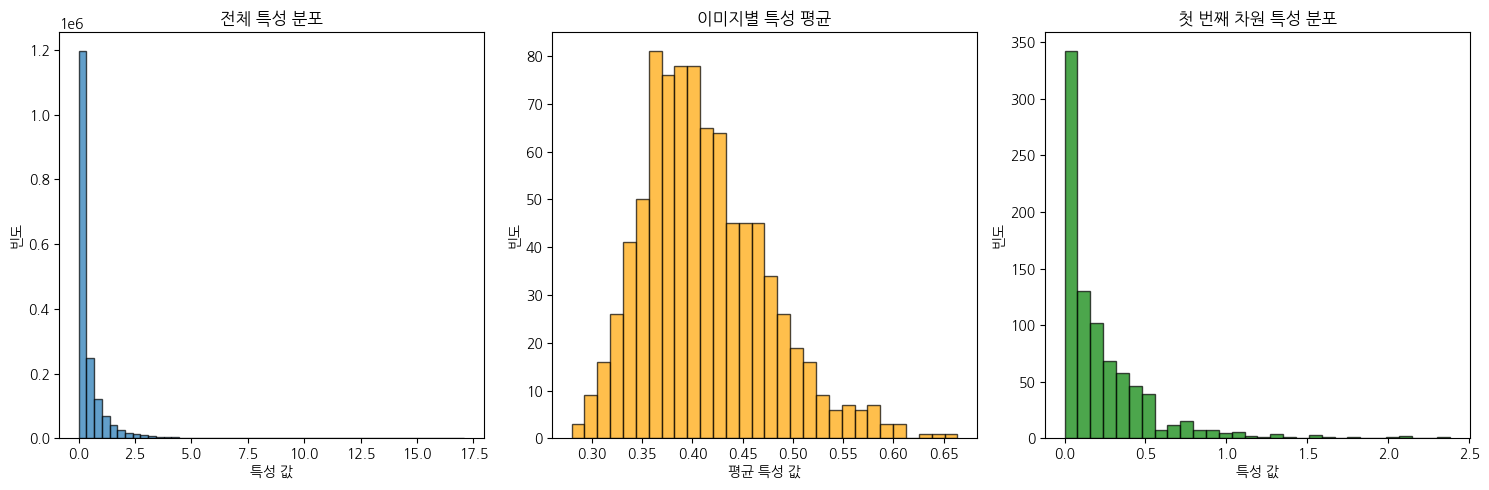


카테고리별 특성 분석:


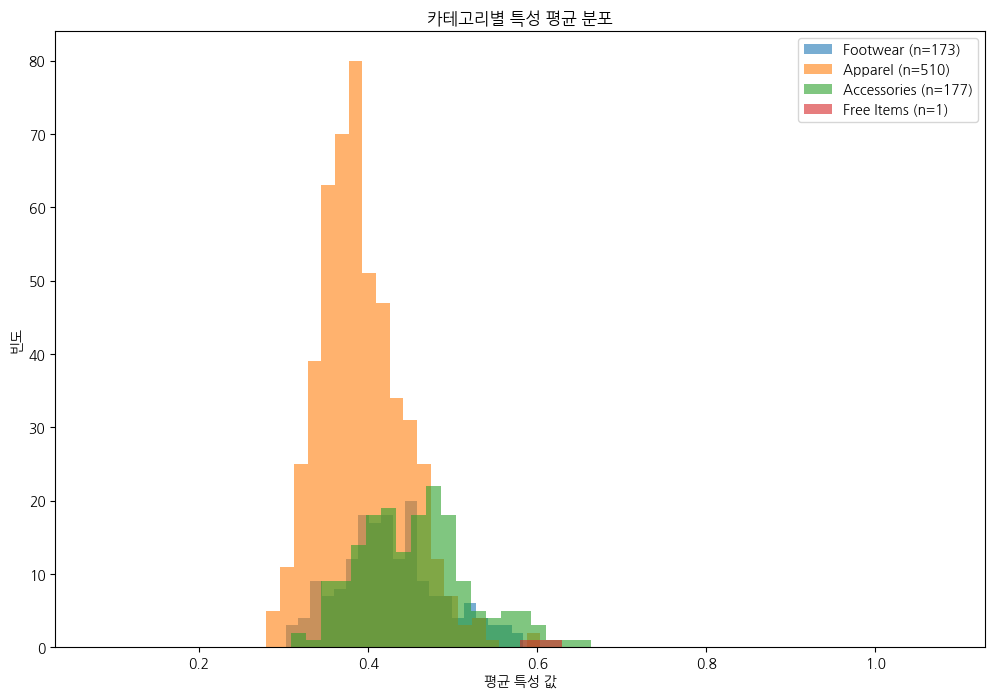

In [39]:
print(f"   평균: {np.mean(features):.6f}")
print(f"   표준편차: {np.std(features):.6f}")
print(f"   최솟값: {np.min(features):.6f}")
print(f"   최댓값: {np.max(features):.6f}")

# 특성 분포 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(features.flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.title('전체 특성 분포')
plt.xlabel('특성 값')
plt.ylabel('빈도')

plt.subplot(1, 3, 2)
feature_means = np.mean(features, axis=1)
plt.hist(feature_means, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('이미지별 특성 평균')
plt.xlabel('평균 특성 값')
plt.ylabel('빈도')

plt.subplot(1, 3, 3)
plt.hist(features[:, 0], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('첫 번째 차원 특성 분포')
plt.xlabel('특성 값')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

# 카테고리별 분석
if 'masterCategory' in valid_styles.columns:
    print(f"\n카테고리별 특성 분석:")
    
    categories = valid_styles['masterCategory'].unique()[:5]
    
    plt.figure(figsize=(12, 8))
    
    for i, category in enumerate(categories):
        cat_indices = valid_styles['masterCategory'] == category
        cat_features = features[cat_indices]
        
        if len(cat_features) > 0:
            cat_mean = np.mean(cat_features, axis=1)
            plt.hist(cat_mean, alpha=0.6, label=f'{category} (n={len(cat_features)})', bins=20)
    
    plt.title('카테고리별 특성 평균 분포')
    plt.xlabel('평균 특성 값')
    plt.ylabel('빈도')
    plt.legend()
    plt.show()

## 유사도 테스트

In [40]:
test_idx = 0
test_feature = features[test_idx].reshape(1, -1)
test_info = valid_styles.iloc[test_idx]

print(f"테스트 이미지 정보:")
print(f"   ID: {test_info['id']}")
if 'productDisplayName' in test_info:
    print(f"   상품명: {test_info['productDisplayName']}")
if 'masterCategory' in test_info:
    print(f"   카테고리: {test_info['masterCategory']}")

similarities = cosine_similarity(test_feature, features)[0]
similar_indices = np.argsort(similarities)[::-1][1:6]

print(f"\n가장 유사한 상품 5개:")
for i, idx in enumerate(similar_indices, 1):
    sim_info = valid_styles.iloc[idx]
    similarity_score = similarities[idx]
    
    print(f"   {i}. ID: {sim_info['id']}, 유사도: {similarity_score:.4f}")
    if 'productDisplayName' in sim_info:
        print(f"      상품명: {sim_info['productDisplayName']}")
    if 'masterCategory' in sim_info:
        print(f"      카테고리: {sim_info['masterCategory']}")

테스트 이미지 정보:
   ID: 10268
   상품명: Clarks Men Hang Work Leather Black Formal Shoes
   카테고리: Footwear

가장 유사한 상품 5개:
   1. ID: 10286, 유사도: 0.9248
      상품명: Clarks Men Hang Tough Leather Black Formal Shoes
      카테고리: Footwear
   2. ID: 10155, 유사도: 0.9137
      상품명: Rockport Men Tr Bal Brown Casual Shoes
      카테고리: Footwear
   3. ID: 10281, 유사도: 0.9124
      상품명: Clarks Men Hang Spring Leather Black Formal Shoes
      카테고리: Footwear
   4. ID: 10264, 유사도: 0.9045
      상품명: Clarks Men Goya Band Leather Black Formal Shoes
      카테고리: Footwear
   5. ID: 10143, 유사도: 0.9032
      상품명: Rockport Men Moc Front Brown Formal Shoes
      카테고리: Footwear


## Summary

In [41]:
print(f"처리 결과")
print(f"   - 총 처리 이미지: {len(styles_work):,}개")
print(f"   - 성공한 이미지: {len(features):,}개")
print(f"   - 특성 벡터 차원: {features.shape[1]}")
print(f"   - 처리 시간: {processing_time:.2f}초")
print(f"   - 평균 속도: {len(features)/processing_time:.1f}개/초")
print(f"")
print(f"저장된 파일")
print(f"   - 임베딩: {tf_embeddings_path}")
print(f"   - 메타데이터: {tf_metadata_path}")
print(f"   - 통계: {tf_stats_path}")
print(f"")

처리 결과
   - 총 처리 이미지: 861개
   - 성공한 이미지: 861개
   - 특성 벡터 차원: 2048
   - 처리 시간: 88.35초
   - 평균 속도: 9.7개/초

저장된 파일
   - 임베딩: ../embeddings\tf_embeddings.npy
   - 메타데이터: ../embeddings\tf_metadata.csv
   - 통계: ../embeddings\tf_stats.csv

